# Seismic Event Detection using SeisBench

This notebook demonstrates the complete workflow for seismic event detection using SeisBench models,
following the approach from real-time detection systems.

## Workflow
1. Load pre-trained SeisBench model (PhaseNet, EQTransformer, or QuakeXNet)
2. Download seismic data from FDSN client
3. Run model inference to get probability predictions
4. Detect event windows from probabilities
5. Interactive visualization for quality control
6. Export results

In [2]:
# Import required libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from src.seisbench_models import create_detector, create_classifier, convert_picks_to_detections
from src.detect import (
    smooth_moving_avg, detect_event_windows, multi_class_detection,
    classify_waveform_windows, merge_picks_and_classifications,
    filter_noise_events, get_event_type_counts
)
from src.interactive_plots import plot_detection_results, interactive_detection_viewer, plot_event_summary
from src.utils import ensure_dir

# For interactive plots in Jupyter
%matplotlib inline

print("✓ Imports successful!")

/Users/marinedenolle/opt/miniconda3/envs/gaia-hazlab/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✓ Imports successful!


## 1. Configuration and Setup

In [3]:
# Configuration
config = {
    # Picker model settings (following SeisBench workflow)
    'picker_model': 'phasenet',  # Options: 'phasenet', 'eqtransformer', 'gpd'
    'picker_version': 'stead',   # Options: 'original', 'ethz', 'instance', 'scedc', 'stead', 'geofon', 'neic'
    
    # Classifier model settings
    'classifier_model': 'quakexnet',
    'classifier_version': 'base',  # Options: 'base', 'v3'
    
    # Device settings
    'device': 'auto',  # 'auto', 'cpu', or 'cuda'
    
    # Data settings
    'network': 'UW',
    'station': 'DREAM',
    'channel': 'HH*',  # HH* for high-bandwidth, BH* for broadband
    'location': '*',
    
    # Time window (use recent data or specify custom)
    'use_recent': False,  # If True, use last 24 hours
    'hours_back': 24,
    'starttime': '2025-12-10T00:00:00',  # Used if use_recent=False
    'endtime': '2025-12-15T00:00:00',
    
    # Picker detection parameters
    'picker_threshold': 0.5,
    'min_duration': 10,  # samples
    'merge_distance': 50,  # samples
    'apply_smoothing': True,
    'smooth_window': 100,
    
    # Classification parameters
    'window_duration': 100.0,  # seconds (for QuakeXNet 5000 samples @ 50Hz)
    'stride': 50.0,  # seconds
    'batch_size': 12,
    'include_sliding': True,
    'include_event_centered': True,
    
    # Merging parameters
    'time_tolerance': 10.0,  # seconds for matching picks to classifications
    
    # Output settings
    'save_plots': True,
    'save_results': True,
}

# Create output directories
ensure_dir('../plots')
ensure_dir('../logs')

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  picker_model: phasenet
  picker_version: stead
  classifier_model: quakexnet
  classifier_version: base
  device: auto
  network: UW
  station: DREAM
  channel: HH*
  location: *
  use_recent: False
  hours_back: 24
  starttime: 2025-12-10T00:00:00
  endtime: 2025-12-15T00:00:00
  picker_threshold: 0.5
  min_duration: 10
  merge_distance: 50
  apply_smoothing: True
  smooth_window: 100
  window_duration: 100.0
  stride: 50.0
  batch_size: 12
  include_sliding: True
  include_event_centered: True
  time_tolerance: 10.0
  save_plots: True
  save_results: True


## 2. Load Models (Parallel Workflow)

We'll load both the picker and classifier models following the SeisBench workflow:
- **Picker**: Detects P and S wave arrivals using `from_pretrained(version)`
  - PhaseNet, EQTransformer, or GPD
  - Multiple pretrained weights: 'stead', 'ethz', 'instance', 'geofon', etc.
- **Classifier**: Classifies events into earthquake, explosion, noise, surface event (QuakeXNet)

In [4]:
# Load picker model (following SeisBench workflow)
print(f"Loading {config['picker_model']} picker...")

picker = create_detector(
    model_name=config['picker_model'],
    version=config['picker_version'],
    device=config['device']
)

print(f"✓ Picker loaded on {picker.device}")
print(f"  Model: {picker.model_name}")
print(f"  Version: {picker.version}")

# Load classifier model
print(f"\nLoading {config['classifier_model']} classifier...")

classifier = create_classifier(
    model_name=config['classifier_model'],
    version=config['classifier_version'],
    device=config['device']
)

print(f"✓ Both models loaded successfully!")

Loading phasenet picker...
Loading phasenet (version: stead) on cpu...
✓ Detector ready
✓ Picker loaded on cpu
  Model: phasenet
  Version: stead

Loading quakexnet classifier...
Creating quakexnet classifier on cpu...
Weights already cached at /Users/marinedenolle/.cache/gaia-landslides/models/quakexnet_base.pt
Loaded weights from /Users/marinedenolle/.cache/gaia-landslides/models/quakexnet_base.pt
✓ Classifier ready
✓ Both models loaded successfully!


## 3. Download Seismic Data

Download data from IRIS/FDSN data center.

In [5]:
# Set up time window - use config settings
if config['use_recent']:
    endtime = UTCDateTime.now()
    starttime = endtime - config['hours_back'] * 3600
else:
    starttime = UTCDateTime(config['starttime'])
    endtime = UTCDateTime(config['endtime'])

print(f"Time window:")
print(f"  Start: {starttime}")
print(f"  End: {endtime}")
print(f"  Duration: {(endtime - starttime) / 3600:.1f} hours")

# Download data
print(f"\nDownloading data for {config['network']}.{config['station']}...")

client = Client("IRIS")

try:
    stream = client.get_waveforms(
        network=config['network'],
        station=config['station'],
        channel=config['channel'],
        location=config['location'],
        starttime=starttime,
        endtime=endtime
    )
    
    print(f"✓ Downloaded {len(stream)} traces")
    print(f"\nStream info:")
    print(stream)
    
except Exception as e:
    print(f"✗ Error downloading data: {e}")
    print("\nTip: Try different station/network or time window")
    raise


Time window:
  Start: 2025-12-10T00:00:00.000000Z
  End: 2025-12-15T00:00:00.000000Z
  Duration: 120.0 hours

✓ Downloaded 6 traces

Stream info:
6 Trace(s) in Stream:
UW.DREAM..HHE | 2025-12-10T00:00:00.000000Z - 2025-12-10T11:50:43.020000Z | 100.0 Hz, 4264303 samples
UW.DREAM..HHE | 2025-12-10T11:50:46.230000Z - 2025-12-14T14:03:48.310000Z | 100.0 Hz, 35358209 samples
UW.DREAM..HHN | 2025-12-10T00:00:00.000000Z - 2025-12-13T14:36:03.020000Z | 100.0 Hz, 31176303 samples
UW.DREAM..HHN | 2025-12-13T14:36:05.310000Z - 2025-12-14T14:03:50.880000Z | 100.0 Hz, 8446558 samples
UW.DREAM..HHZ | 2025-12-10T00:00:00.000000Z - 2025-12-11T18:39:37.120000Z | 100.0 Hz, 15357713 samples
UW.DREAM..HHZ | 2025-12-11T18:39:39.210000Z - 2025-12-14T14:10:09.680000Z | 100.0 Hz, 24303048 samples
✓ Downloaded 6 traces

Stream info:
6 Trace(s) in Stream:
UW.DREAM..HHE | 2025-12-10T00:00:00.000000Z - 2025-12-10T11:50:43.020000Z | 100.0 Hz, 4264303 samples
UW.DREAM..HHE | 2025-12-10T11:50:46.230000Z - 2025-12-14

In [6]:
stream.merge(method=1, fill_value=0)

3 Trace(s) in Stream:
UW.DREAM..HHE | 2025-12-10T00:00:00.000000Z - 2025-12-14T14:03:48.310000Z | 100.0 Hz, 39622832 samples
UW.DREAM..HHN | 2025-12-10T00:00:00.000000Z - 2025-12-14T14:03:50.880000Z | 100.0 Hz, 39623089 samples
UW.DREAM..HHZ | 2025-12-10T00:00:00.000000Z - 2025-12-14T14:10:09.680000Z | 100.0 Hz, 39660969 samples

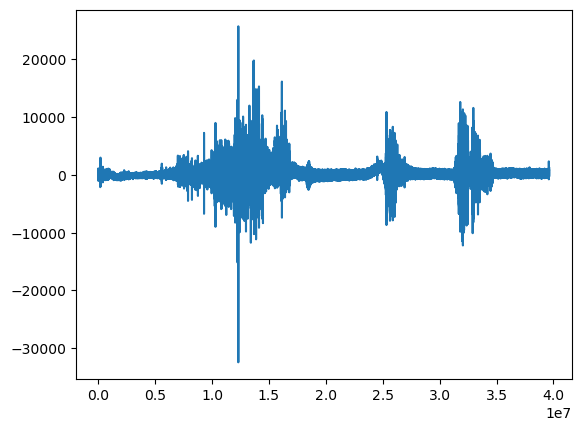

In [7]:
plt.plot(stream[1].data)

In [8]:
import seisbench
import seisbench.models as sbm
pn_model = sbm.PhaseNet.from_pretrained("stead")
pn_preds = pn_model.annotate(stream)

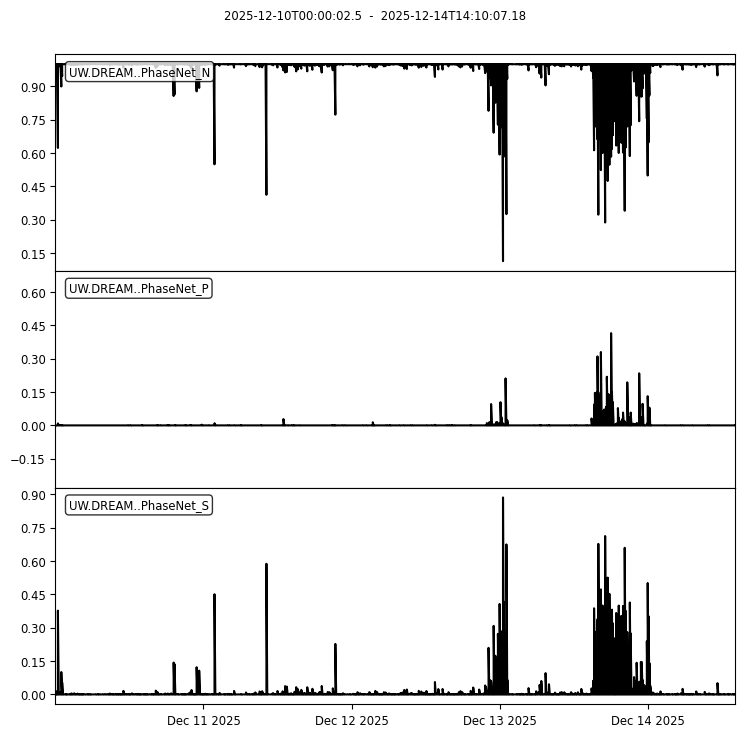

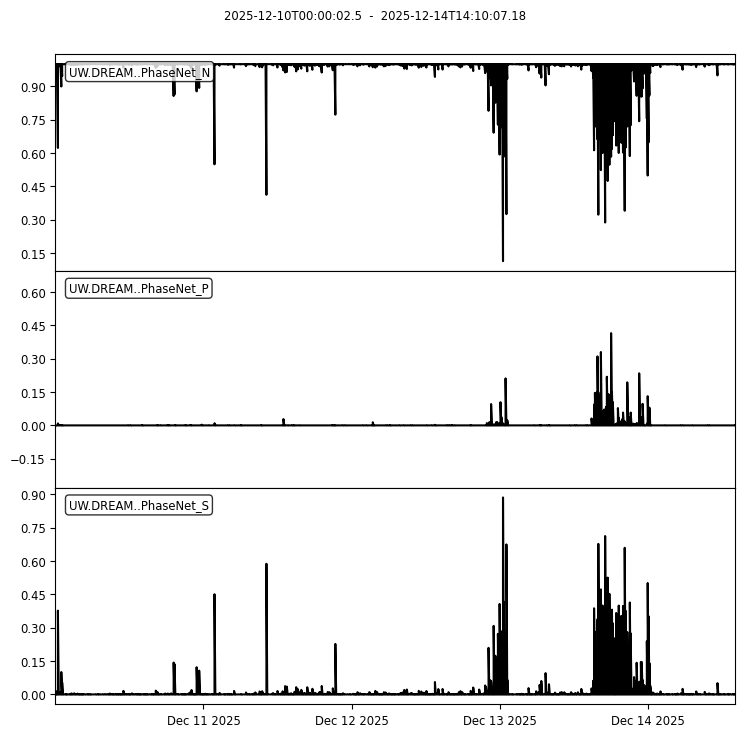

In [9]:
pn_preds.plot()

In [ ]:
# Optimized version - much faster timezone conversion
from obspy import read_inventory
from datetime import timezone
import pytz
import matplotlib.dates as mdates

# Get local timezone
local_tz = pytz.timezone('America/Los_Angeles')

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for i, tr in enumerate(stream):
    # Efficient: convert starttime once, then add time offsets
    start_datetime = tr.stats.starttime.datetime.replace(tzinfo=timezone.utc)
    start_local = start_datetime.astimezone(local_tz)
    
    # Create time array by adding seconds as timedeltas (much faster)
    times_local = [start_local + pd.Timedelta(seconds=float(t)) for t in tr.times()]
    
    # Plot
    axes[i].plot(times_local, tr.data, 'k-', linewidth=0.5)
    axes[i].set_ylabel(f'{tr.stats.channel}\nVelocity (m/s)', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].text(0.01, 0.95, f'{tr.stats.network}.{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}',
                transform=axes[i].transAxes, fontsize=9, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Format x-axis with local time
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M', tz=local_tz))
axes[-1].xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[-1].set_xlabel(f'Time ({local_tz.zone})', fontsize=11)

fig.suptitle(f'{config["network"]}.{config["station"]} - Response Corrected (Velocity)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()

if config['save_plots']:
    save_path = f"../plots/{config['station']}_{starttime.date}_corrected.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Plot saved to {save_path}")

plt.show()


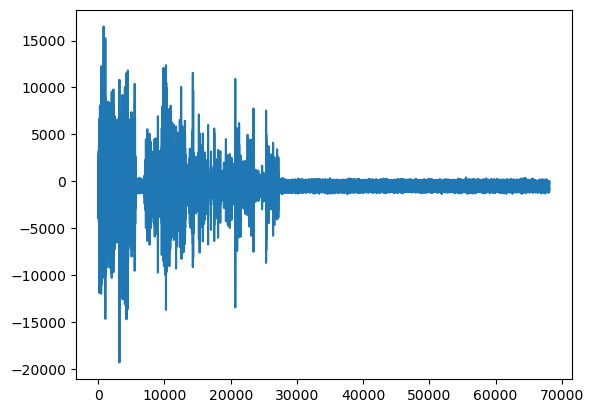

In [ ]:
plt.plot(stream[0].times(), stream[0].data)

In [ ]:
outputs = pn_model.classify(stream)

In [ ]:
import pandas as pd

# Output file
output_file = 'seisbench_detections_%s.%s.%s.%s.csv'%(stream[0].stats.network,stream[0].stats.station,stream[0].stats.starttime.year,stream[0].stats.starttime.julday)

# Reformat output to desired structure
formatted = []
for ii in range(len(outputs.picks)):
    formatted.append({
        'phase': outputs.picks[ii].__dict__['phase'],
        'time': outputs.picks[ii].__dict__['peak_time'],  # Convert UTCDateTime to ISO 8601 string
        'confidence':  outputs.picks[ii].__dict__['peak_value']
    })

# Convert to DataFrame
df = pd.DataFrame(formatted)

# Optional: Save to CSV
df.to_csv(output_file, index=False)

! head seisbench_detections_*.csv

phase,time,confidence
S,2025-12-13T21:28:38.930000Z,0.80305886
S,2025-12-13T22:58:36.790000Z,0.28116992
S,2025-12-14T01:08:15.470000Z,0.6869321


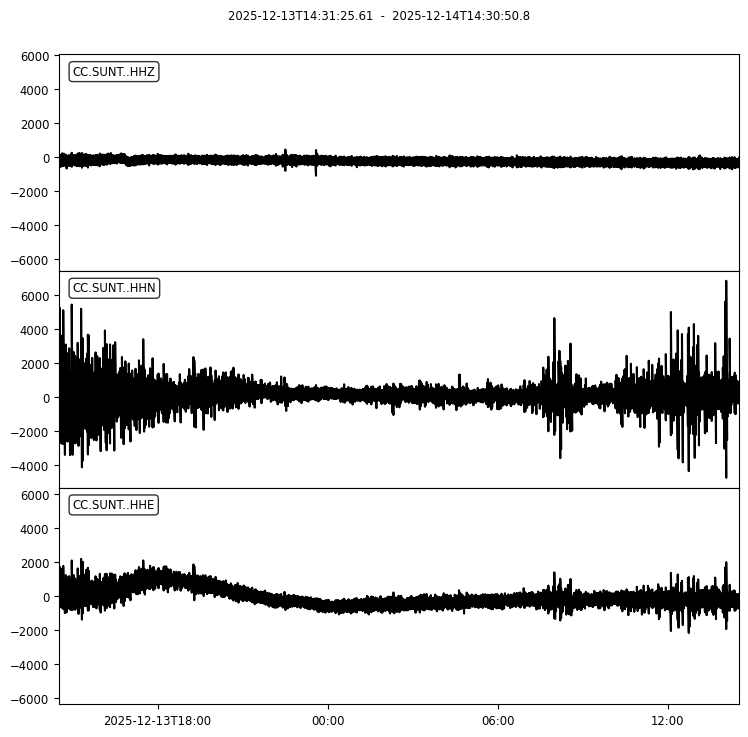

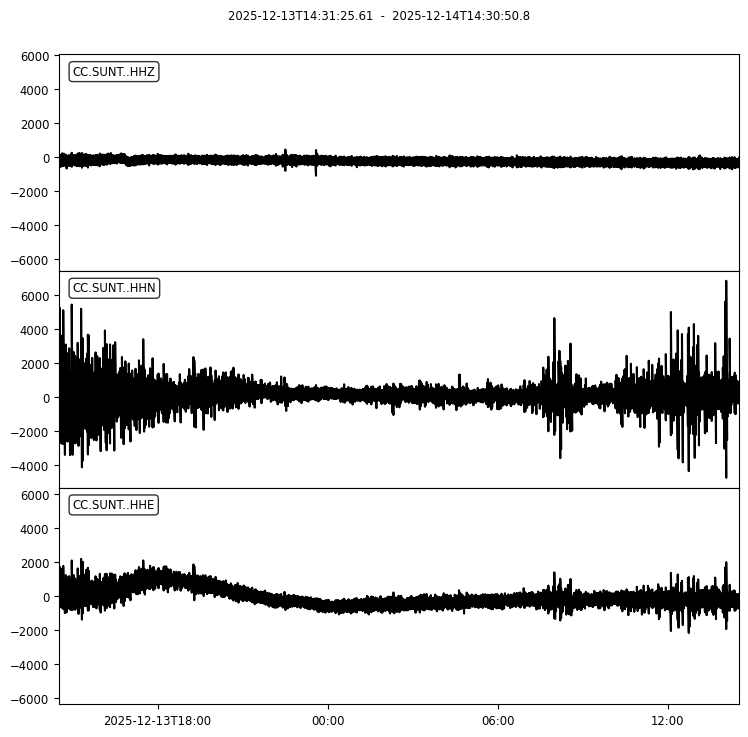

In [ ]:
stream.merge(method=1, fill_value=0).plot()

Filtered stream between 1-20 Hz
Original stream: 3 traces
Filtered stream: 3 traces


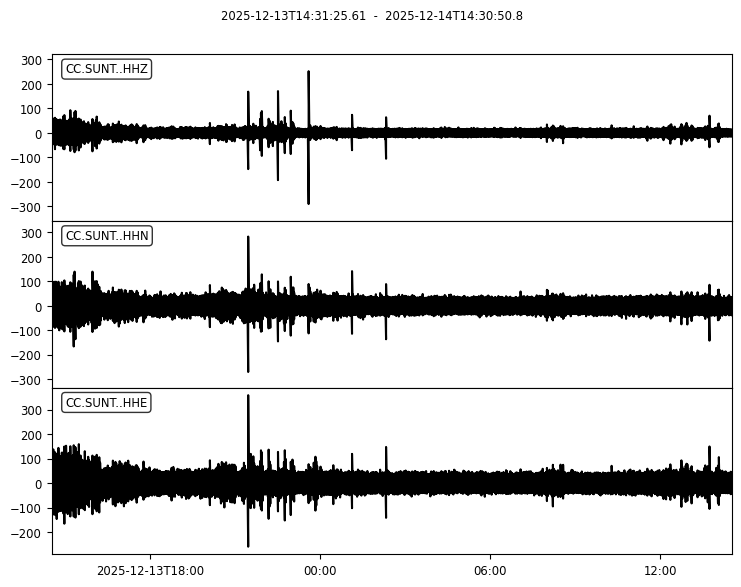

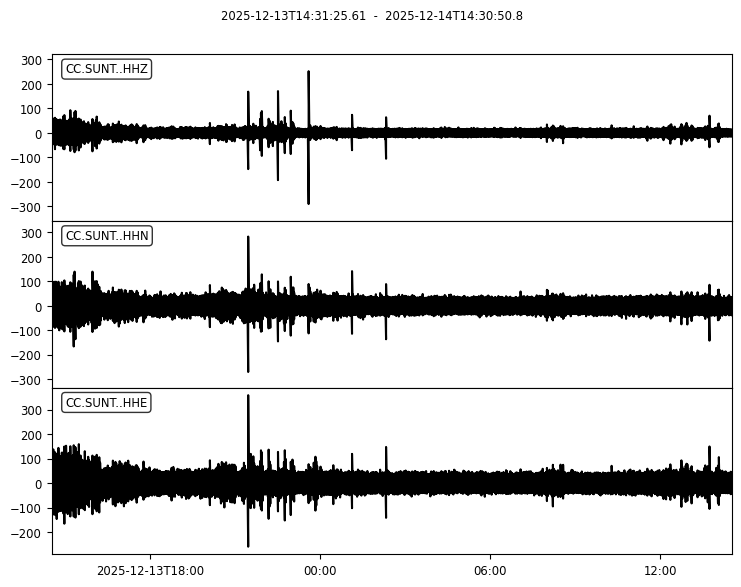

In [ ]:
# Filter stream between 1-20 Hz and plot
stream_filtered = stream.copy()
stream_filtered.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=4, zerophase=True)

print(f"Filtered stream between 1-20 Hz")
print(f"Original stream: {len(stream)} traces")
print(f"Filtered stream: {len(stream_filtered)} traces")

# Plot filtered waveforms
stream_filtered.plot(size=(800, 600))

## 4A. Phase Picking - Run Picker Inference

Use the picker model to detect P and S wave arrivals.

In [ ]:
print("Running picker inference...")

# Use SeisBench workflow directly (as shown in cells above)
# This is the simplest and most reliable approach
annotated_stream = picker.model.annotate(stream)

print(f"✓ Picker inference complete")
print(f"\nAnnotated stream (probability traces):")
print(annotated_stream)

# Extract predictions by phase
# The annotated stream contains traces with channels like "PhaseNet_P", "PhaseNet_S", "PhaseNet_N"
pick_probabilities = picker._extract_predictions(annotated_stream)

print(f"\nPicker prediction classes:")
for class_name, probs in pick_probabilities.items():
    print(f"  {class_name}: {len(probs)} samples, max prob: {np.max(probs):.3f}")
    
# Alternative: Use classify() for deterministic picks
print("\n--- Deterministic Picks (using classify()) ---")
picks_output = picker.model.classify(stream)
print(f"Deterministic picks: {len(picks_output.picks)} picks found")

if len(picks_output.picks) > 0:
    # Show first few picks
    for i, pick in enumerate(picks_output.picks[:5]):
        print(f"  Pick {i+1}: {pick.phase} at {pick.peak_time} (prob: {pick.peak_value:.3f})")
    
    # Convert to our detection format for compatibility with downstream analysis
    pick_detections_from_classify = convert_picks_to_detections(
        picks_output, 
        sampling_rate=stream[0].stats.sampling_rate,
        stream_starttime=stream[0].stats.starttime
    )
    
    print(f"\nConverted to detection format:")
    for phase, picks in pick_detections_from_classify.items():
        print(f"  {phase}: {len(picks)} picks")


Running picker inference...
✓ Picker inference complete

Annotated stream (probability traces):
3 Trace(s) in Stream:
CC.SUNT..PhaseNet_P | 2025-12-13T14:31:28.110000Z - 2025-12-14T14:30:48.300000Z | 100.0 Hz, 8636020 samples
CC.SUNT..PhaseNet_S | 2025-12-13T14:31:28.110000Z - 2025-12-14T14:30:48.300000Z | 100.0 Hz, 8636020 samples
CC.SUNT..PhaseNet_N | 2025-12-13T14:31:28.110000Z - 2025-12-14T14:30:48.300000Z | 100.0 Hz, 8636020 samples

Picker prediction classes:
  P: 8636020 samples, max prob: 0.226
  S: 8636020 samples, max prob: 0.803
  Noise: 8636020 samples, max prob: 1.000

--- Deterministic Picks (using classify()) ---
✓ Picker inference complete

Annotated stream (probability traces):
3 Trace(s) in Stream:
CC.SUNT..PhaseNet_P | 2025-12-13T14:31:28.110000Z - 2025-12-14T14:30:48.300000Z | 100.0 Hz, 8636020 samples
CC.SUNT..PhaseNet_S | 2025-12-13T14:31:28.110000Z - 2025-12-14T14:30:48.300000Z | 100.0 Hz, 8636020 samples
CC.SUNT..PhaseNet_N | 2025-12-13T14:31:28.110000Z - 2025-1

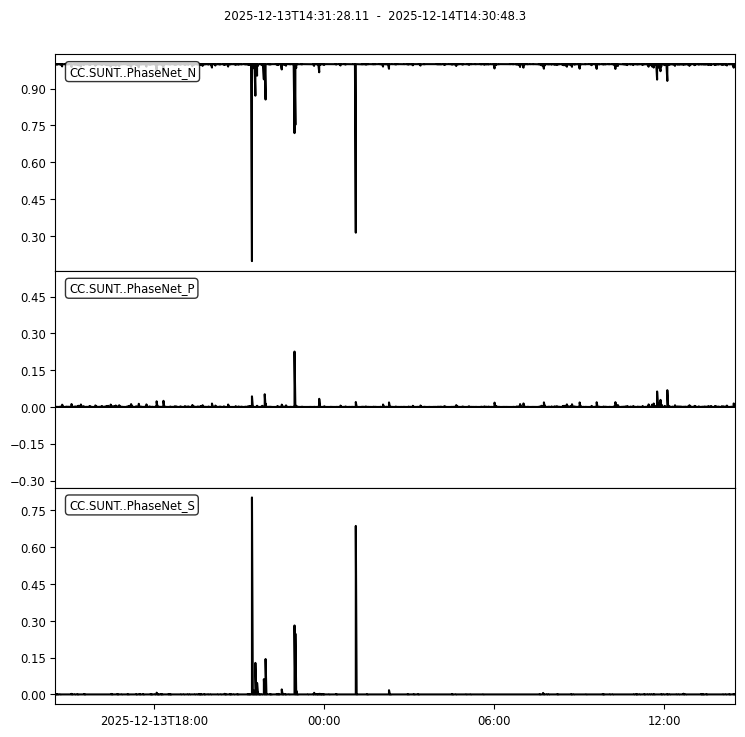

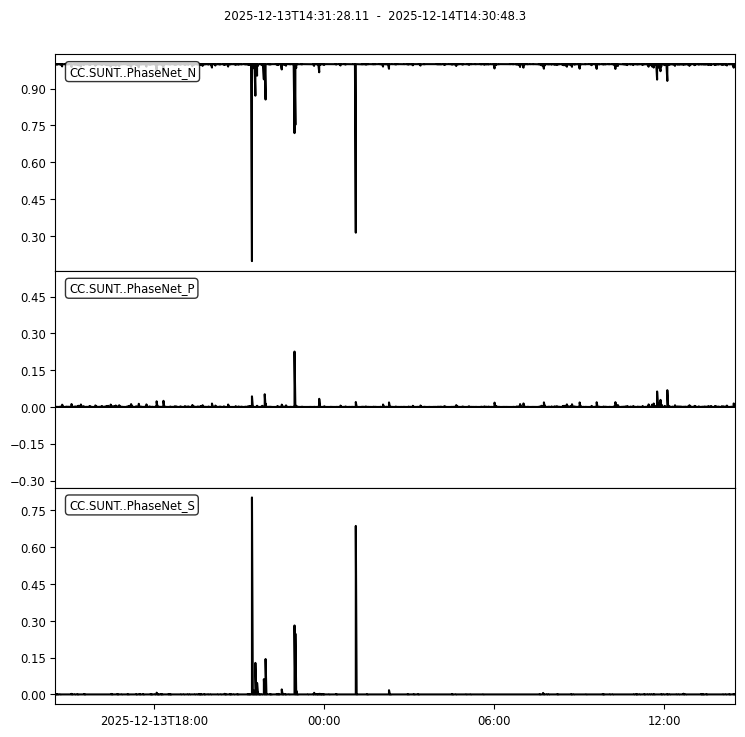

In [ ]:
annotated_stream.plot()

## 4B. Phase Picking - Detect Pick Windows

Apply smoothing and threshold-based detection to find P and S picks.

In [ ]:
print("Detecting pick windows from probability traces...")

# Approach 1: Use probability-based detection on annotated stream
# This applies threshold-based detection to the probability traces
pick_detections = multi_class_detection(
    pick_probabilities,
    threshold=config['picker_threshold'],
    min_duration=config['min_duration'],
    merge_distance=config['merge_distance'],
    apply_smoothing=config['apply_smoothing'],
    smooth_window=config['smooth_window']
)

print(f"✓ Pick detection complete (from probabilities)")
print(f"\nDetected picks from probability thresholding:")
total_picks = 0
for phase_name, phase_picks in pick_detections.items():
    print(f"  {phase_name}: {len(phase_picks)} picks")
    total_picks += len(phase_picks)

print(f"\nTotal picks from probabilities: {total_picks}")

# Approach 2: Use SeisBench's built-in classify() picks
# These are already deterministic picks with peak detection
if 'pick_detections_from_classify' in locals():
    print(f"\n--- Comparison with SeisBench classify() ---")
    total_classify = sum(len(picks) for picks in pick_detections_from_classify.values())
    print(f"Total picks from classify(): {total_classify}")
    for phase_name, phase_picks in pick_detections_from_classify.items():
        print(f"  {phase_name}: {len(phase_picks)} picks")
    
    # You can choose which to use for downstream analysis
    print("\nNote: Using probability-based detections for downstream analysis.")
    print("To use classify() picks instead, set: pick_detections = pick_detections_from_classify")


Detecting pick windows from probability traces...
✓ Pick detection complete (from probabilities)

Detected picks from probability thresholding:
  P: 0 picks
  S: 0 picks
  Noise: 1 picks

Total picks from probabilities: 1

--- Comparison with SeisBench classify() ---
Total picks from classify(): 3
  S: 3 picks

Note: Using probability-based detections for downstream analysis.
To use classify() picks instead, set: pick_detections = pick_detections_from_classify
✓ Pick detection complete (from probabilities)

Detected picks from probability thresholding:
  P: 0 picks
  S: 0 picks
  Noise: 1 picks

Total picks from probabilities: 1

--- Comparison with SeisBench classify() ---
Total picks from classify(): 3
  S: 3 picks

Note: Using probability-based detections for downstream analysis.
To use classify() picks instead, set: pick_detections = pick_detections_from_classify


## 5A. Event Classification - Run Classifier (Parallel)

Run the QuakeXNet classifier using hybrid approach:
- Sliding windows across entire stream
- Event-centered windows on detected picks

In [ ]:
print("Running event classification...")

# Run hybrid classification (sliding + event-centered)
classification_results = classify_waveform_windows(
    stream=stream,
    classifier=classifier,
    picker_detections=pick_detections,
    window_duration=config['window_duration'],
    stride=config['stride'],
    batch_size=config['batch_size'],
    include_sliding=config['include_sliding'],
    include_event_centered=config['include_event_centered']
)

print(f"\n✓ Classification complete")
print(f"Total windows classified: {len(classification_results)}")

# Show classification distribution
if classification_results:
    class_labels = [r['class_label'] for r in classification_results]
    print("\nClassification distribution:")
    for label in ['eq', 'px', 'no', 'su']:
        count = class_labels.count(label)
        print(f"  {label}: {count}")
    
    # Create classification DataFrame for easier viewing
    df_classifications = pd.DataFrame(classification_results)
    print(f"\nClassification results preview:")
    print(df_classifications.head(10))

Running event classification...
Processing 1726 sliding windows...
Processing 1726 sliding windows...


Classifying windows:   0%|          | 0/144 [00:00<?, ?it/s]



RuntimeError: Given groups=1, weight of size [8, 3, 3, 3], expected input[1, 12, 3, 5000] to have 3 channels, but got 12 channels instead

## 5B. Merge Picks and Classifications

Match picks with classifications based on temporal overlap (±10s tolerance).

In [ ]:
print("Merging picks and classifications...")

# Prepare picker results for merging
sampling_rate = stream[0].stats.sampling_rate
picker_results = []

for phase_name, phase_picks in pick_detections.items():
    for pick in phase_picks:
        pick_record = pick.copy()
        pick_record['phase'] = phase_name
        pick_record['class_name'] = phase_name
        picker_results.append(pick_record)

# Merge results
df_merged = merge_picks_and_classifications(
    picker_results=picker_results,
    classification_results=classification_results,
    time_tolerance=config['time_tolerance'],
    sampling_rate=sampling_rate
)

print(f"✓ Merging complete")
print(f"\nMerged events summary:")
print(f"  Total events: {len(df_merged)}")
print(f"  Matched (pick + class): {len(df_merged[df_merged['match_type'] == 'matched'])}")
print(f"  Pick only: {len(df_merged[df_merged['match_type'] == 'pick_only'])}")
print(f"  Classification only: {len(df_merged[df_merged['match_type'] == 'class_only'])}")

print(f"\nMerged results preview:")
print(df_merged.head(20))

# Save merged results
if config['save_results']:
    csv_path = f"../logs/{config['station']}_{starttime.date}_merged_events.csv"
    df_merged.to_csv(csv_path, index=False)
    print(f"\n✓ Merged results saved to {csv_path}")

## 6. Visualization - Picker Results

Plot waveforms with phase pick probabilities and detected picks.

In [ ]:
# Plot picker results
save_path = None
if config['save_plots']:
    save_path = f"../plots/{config['station']}_{starttime.date}_picks.png"

fig, axes = plot_detection_results(
    stream,
    pick_probabilities,
    pick_detections,
    sampling_rate=sampling_rate,
    figsize=(15, 10),
    save_path=save_path
)

plt.show()

## 7. Analysis - Event Statistics and Summary

In [ ]:
# Summary statistics by match type
print("\n" + "="*70)
print("DETECTION SUMMARY")
print("="*70)
print(f"Station: {config['network']}.{config['station']}")
print(f"Time window: {starttime} to {endtime}")
print(f"Duration: {(endtime - starttime) / 3600:.1f} hours")
print(f"\nTotal events: {len(df_merged)}")

print("\n--- By Match Type ---")
print(df_merged['match_type'].value_counts())

print("\n--- By Event Class (classifications) ---")
class_counts = df_merged[df_merged['class_label'].notna()]['class_label'].value_counts()
print(class_counts)

print("\n--- By Phase (picks) ---")
phase_counts = df_merged[df_merged['pick_phase'].notna()]['pick_phase'].value_counts()
print(phase_counts)

# Matched events statistics
matched_events = df_merged[df_merged['match_type'] == 'matched']
if len(matched_events) > 0:
    print(f"\n--- Matched Events (n={len(matched_events)}) ---")
    print("Average time difference between pick and classification:")
    print(f"  Mean: {matched_events['time_diff'].mean():.2f} seconds")
    print(f"  Median: {matched_events['time_diff'].median():.2f} seconds")
    print(f"  Max: {matched_events['time_diff'].max():.2f} seconds")
    
    print("\nPhase vs Classification cross-tabulation:")
    if len(matched_events) > 0:
        crosstab = pd.crosstab(matched_events['pick_phase'], matched_events['class_label'])
        print(crosstab)

print("="*70)

## 8. Filter and Export Results

Filter results by match type or event class, and export for further analysis.

In [ ]:
# Example filters

# 1. Get only matched events (both pick and classification)
matched_only = df_merged[df_merged['match_type'] == 'matched']
print(f"Matched events only: {len(matched_only)}")

# 2. Filter out noise classifications
non_noise = df_merged[df_merged['class_label'] != 'no']
print(f"Non-noise events: {len(non_noise)}")

# 3. Get only earthquakes
earthquakes = df_merged[df_merged['class_label'] == 'eq']
print(f"Earthquake events: {len(earthquakes)}")

# 4. Get only surface events (landslides, etc.)
surface_events = df_merged[df_merged['class_label'] == 'su']
print(f"Surface events: {len(surface_events)}")
print("\nSurface events detail:")
print(surface_events[['pick_time', 'pick_phase', 'class_label', 'class_prob', 'match_type']])

# 5. Get picks without classification (might be interesting events picker found)
picks_only = df_merged[df_merged['match_type'] == 'pick_only']
print(f"\nPicks without classification: {len(picks_only)}")

# 6. Get classifications without picks (events picker missed)
class_only = df_merged[df_merged['match_type'] == 'class_only']
print(f"Classifications without picks: {len(class_only)}")

# Save filtered results
if config['save_results'] and len(surface_events) > 0:
    surface_csv = f"../logs/{config['station']}_{starttime.date}_surface_events.csv"
    surface_events.to_csv(surface_csv, index=False)
    print(f"\n✓ Surface events saved to {surface_csv}")

## Next Steps

### Workflow Summary
This notebook implements a two-step parallel workflow:
1. **Phase Picking**: PhaseNet/EQTransformer detects P and S wave arrivals
2. **Event Classification**: QuakeXNet classifies waveform windows into event types
3. **Merging**: Combines picks and classifications based on temporal overlap

### Key Features
- **Hybrid classification**: Both sliding windows and event-centered windows
- **Flexible merging**: Matches picks to classifications within ±10s tolerance
- **Complete catalog**: Preserves unmatched picks (picker-only) and classifications (classifier-only)
- **Event types**: Distinguishes earthquakes (eq), explosions (px), noise (no), surface events (su)

### Further Analysis
- **Try different models**: Experiment with EQTransformer picker or different QuakeXNet versions
- **Adjust parameters**: Tune thresholds, window sizes, and merging tolerance
- **Process multiple stations**: Loop through station lists for network-wide detection
- **Time series analysis**: Track surface event frequency over time
- **Correlation with catalogs**: Compare with known earthquake catalogs
- **Custom filtering**: Develop event-specific quality control criteria

### References
- SeisBench Documentation: https://seisbench.readthedocs.io/
- ObsPy Documentation: https://docs.obspy.org/
- QuakeScope Models: https://github.com/SeisSCOPED/QuakeScope
- QuakeXNet Paper: Kharita et al., AGU24 (2024)